In [1]:
import notebooks.src.visualizingrestatements.visualizingrestatements as vs

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import boto3
import time
import sys
import os
from contextlib import contextmanager
from io import StringIO
from collections import defaultdict
from botocore.config import Config
from stations.station import df_from_s3_csv, df_to_s3_csv
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from math import ceil

In [3]:
ACCESS_KEY_ID = # add yours here
SECRET_ACCESS_KEY = # add yours here
creds_dict = {
    'aws_access_key_id': ACCESS_KEY_ID,
    'aws_secret_access_key': SECRET_ACCESS_KEY,
    'region_name': "us-west-2",
    'config': Config(s3={"use_accelerate_endpoint": True})
}


# Acquire Data

In [4]:
state = "California"
col = "deaths"
data_title = f'JHU {state} {col}'
df = df_from_s3_csv(bucket='us-formatted-data', key=f'JHU/US/{state}//{col}/data.csv', **creds_dict)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.columns = pd.to_datetime(df.columns, format="%Y-%m-%d")

Attempting to read S3 object JHU/US/California//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/California//deaths/data.csv in us-formatted-data


# Basic Restatement Stats

In [5]:
rdict = vs.major_restatements(df, 0)

In [6]:
rdf = pd.DataFrame(rdict["restatements_details"]).T

In [7]:
# number of restatements
len(rdf.index) / len(df.index)

0.17407407407407408

In [8]:
rdf["number"].sum()

3201.0

In [9]:
rdf

,mean,stdev,median,number,percent_changed
2020-04-16,-0.235294,0.424183,0.0,4.0,0.235294
2020-06-15,0.012987,0.113218,0.0,1.0,0.012987
2020-08-15,0.507246,5.937167,0.0,1.0,0.007246
2020-08-16,-0.507246,5.937167,0.0,1.0,0.007246
2021-01-19,8.169492,23.477470,0.0,65.0,0.220339
...,...,...,...,...,...
2021-11-10,-0.030508,0.740420,0.0,1.0,0.001695
2022-03-17,-2.658298,2.860612,-2.0,462.0,0.644351
2022-03-25,0.034483,0.927836,0.0,1.0,0.001379
2022-04-14,0.016107,0.439351,0.0,1.0,0.001342


# May 2022 "Flattened Curve"

In [9]:
start = '2022-04-18'
stop = '2022-05-09'
prior= df['2022-05-08'].dropna()[start: stop]
post = df['2022-05-09'].dropna()[start: stop]


In [10]:
# Is there any difference between initial and first released values?
fr_to_fer = rdict['first_reported']['2022-04-04':stop][:-1] - rdict['first_expected_reported']['2022-04-04':stop][:-1]
fr_to_fer[fr_to_fer !=0]

2022-04-13   -12.0
dtype: float64

## Initial Values

In [11]:
table = pd.concat([rdict["first_reported"][start: stop], rdict["first_reported"][start: stop].diff()], axis=1)
table.columns = ["Cumulative Deaths", "Daily Deaths"]
vs.df_to_latex(
    table.iloc[1:, :],
    "Detail of California Deaths (JHU)"
)


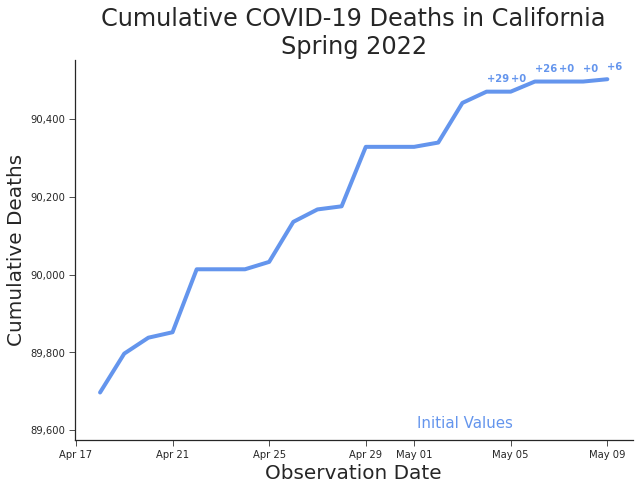

In [12]:
plt.close("all")
plt, ax, setupdct = vs.setup_plot(
    df,
    title="",
    data_title="Cumulative COVID-19 Deaths in California\nSpring 2022", x_label="Observation Date", y_label="Cumulative Deaths",
    num_rows=1, num_cols=1, y_scale="linear"
)

xs = rdict["first_reported"][start: stop].index
ys = rdict["first_reported"][start: stop]
plt.plot(ys, lw=4, color='cornflowerblue')
plt.ylim(min(prior.min(), post.min()) - 10, max(prior.max(), post.max()) + 50 )
ax.get_yaxis().set_major_formatter(mtk.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.title("Cumulative COVID-19 Deaths in California\nSpring 2022")
plt.gcf().text(.6, .15, 'Initial Values',color='cornflowerblue', fontsize=15)

for i in range(1,7):
    x, y, val = xs[-i], ys[-i] + 25, ys.diff()[-i]
    ax.text( x , y , f'+{int(val)}', color="cornflowerblue", size=10, weight="bold")


plt.savefig("../latex/plots/simulations/JHU_California_deaths_restatement_detail_2022-05-09_fr.png")

## Restatements

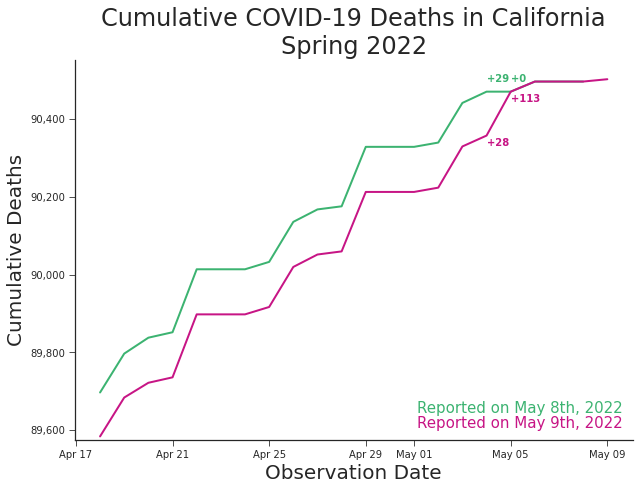

In [13]:
plt.close("all")
plt, ax, setupdct = vs.setup_plot(
    df,
    title="",
    data_title="Cumulative COVID-19 Deaths in California\n Spring 2022", x_label="Observation Date", y_label="Cumulative Deaths",
    num_rows=1, num_cols=1, y_scale="linear"
)

plt.plot(prior.index, prior, lw=2, color='mediumseagreen')
plt.plot(post.index, post, lw=2, color='mediumvioletred')
plt.ylim(min(prior.min(), post.min()) - 10, max(prior.max(), post.max()) + 50 )
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().text(.6, .18, 'Reported on May 8th, 2022',color='mediumseagreen', fontsize=15)
plt.gcf().text(.6, .15, 'Reported on May 9th, 2022',color='mediumvioletred', fontsize=15)
ax.get_yaxis().set_major_formatter(mtk.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title("Cumulative COVID-19 Deaths in California\nSpring 2022")
xs = post.index
for i in range(5,7):
    y_prior, val_prior = prior[-i +1 ] + 25, prior.diff()[-i+1 ]
    x, y_post, val_post = xs[-i], post[-i] - 25, post.diff()[-i]
    ax.text( x , y_prior , f'+{int(val_prior)}', color="mediumseagreen", size=10, weight="bold")
    ax.text( x , y_post , f'+{int(val_post)}', color="mediumvioletred", size=10, weight="bold")

plt.savefig("../latex/plots/simulations/JHU_California_deaths_restatement_detail_2022-05-09.png")


## Weekly Cadence

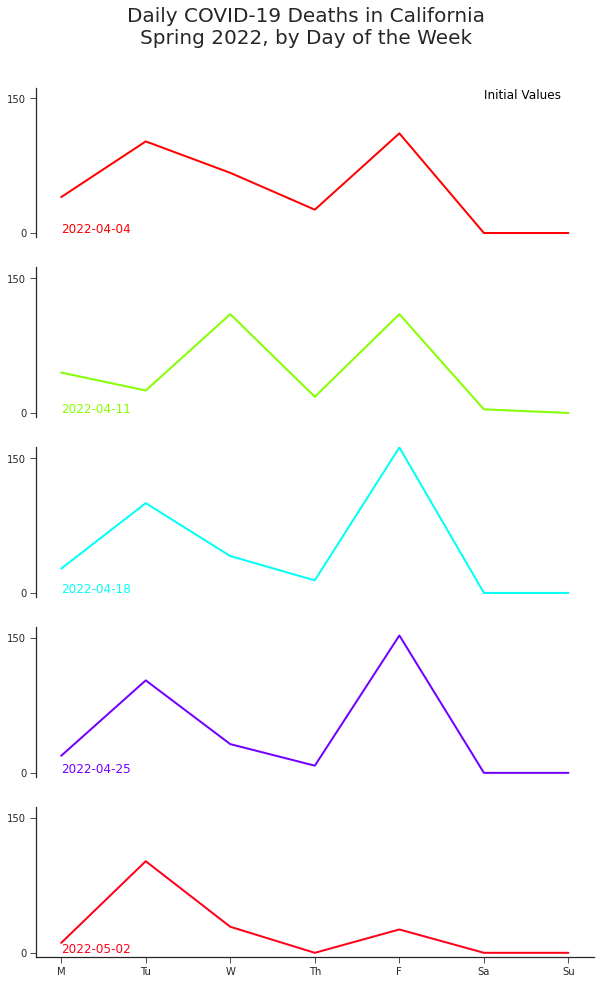

In [14]:
plt.close("all")
stop = '2022-05-09'
fr = rdict["first_reported"].diff().dropna()['2022-04-04':stop][:-1]
colors = plt.cm.hsv(np.linspace(0, 1, ceil(len(fr) /7)  ))
cutoffs =  range(0, len(fr), 7)

fig, axs = plt.subplots(len(cutoffs), 1, sharex=True, figsize=(10, 16))
max_y = fr.max()
min_y = fr.min()
for j, i in enumerate(cutoffs):

    ax1 = axs[j]
    beg, end = i, min(i+7, len(fr))
    if beg < len(fr):
        ind = [d.weekday() for d in fr.index[beg:end]]
        ax1.plot(ind, fr[beg:end], lw=2, color=colors[j])

    ax1.set_ylim(min_y -5, max_y)
    ax1.set_yticks([0, 150])
    ax1.xaxis.set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    week_of = fr.index[beg].strftime('%Y-%m-%d')
    ax1.text(0, 0.5, f'{week_of}', color=colors[j], fontsize=12)
    
    if j == 0:
        ax1.text(5, 150, f'Initial Values', color="black", size=12)
    
ax1.xaxis.set_visible(True)
ax1.spines["bottom"].set_visible(True)
plt.xticks(range(7), ["M", "Tu", "W", "Th", "F", "Sa", "Su"])
fig.suptitle("Daily COVID-19 Deaths in California\nSpring 2022, by Day of the Week", size=20, y=.95)
plt.savefig("../latex/plots/simulations/JHU_California_deaths_detail_2022-05-09_weekly_fr.png")

### Plot Restatement

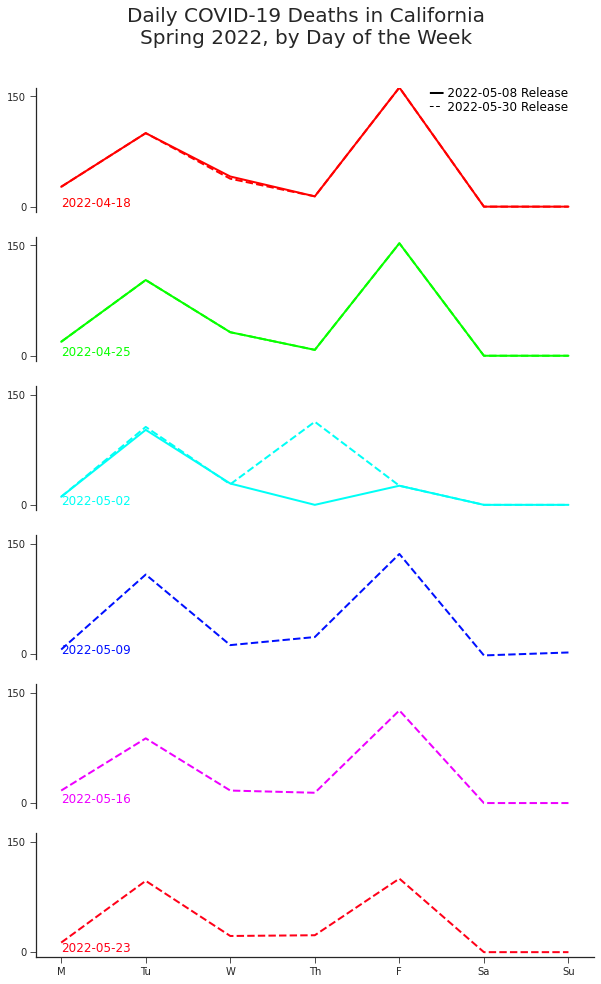

In [15]:
plt.close("all")
start = '2022-04-18'
stop = '2022-05-29'
prior= df.diff()['2022-05-08'].dropna()[start: stop]
post = df.diff()['2022-05-30'].dropna()[start: stop]

colors = plt.cm.hsv(np.linspace(0, 1, 1 + ceil(len(post) /7)  ))
cutoffs =  range(0, len(post), 7)

fig, axs = plt.subplots(len(cutoffs), 1, sharex=True, figsize=(10, 16))
max_y = max(post.max(), prior.max())
min_y = min(post.min(), prior.min())

for j, i in enumerate(cutoffs):

    sky = j
    if sky > 0 :
        sky +=1
    ax1 = axs[j]
    beg, end = i, min(i+7, len(prior))
    if beg < len(prior):
        ind = [d.weekday() for d in prior.index[beg:end]]
        ax1.plot(ind, prior[beg:end], lw=2, color=colors[sky])

    ax1.set_ylim(min_y -5, max_y)
    ax1.set_yticks([0, 150])
    beg, end = i, min(i+7, len(post))
    ind = [d.weekday() for d in post.index[beg:end]]
    ax1.plot(ind, post[beg:end], "--", lw=2,  color=colors[sky])
    ax1.xaxis.set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    week_of = post.index[beg].strftime('%Y-%m-%d')
    ax1.text(0, 0.5, f'{week_of}', color=colors[sky], fontsize=12)
    
    if j == 0:
        ax1.text(4.35, 150, f'━━ 2022-05-08 Release', color="black", size=12)
        ax1.text(4.35, 130, f'╴╴ 2022-05-30 Release', color="black", size=12)
    
ax1.xaxis.set_visible(True)
ax1.spines["bottom"].set_visible(True)
plt.xticks(range(7), ["M", "Tu", "W", "Th", "F", "Sa", "Su"])
fig.suptitle("Daily COVID-19 Deaths in California\nSpring 2022, by Day of the Week", size=20, y=.95)
plt.savefig("../latex/plots/simulations/JHU_California_deaths_restatement_detail_2022-05-09_weekly.png")

# June 2021: Negative Deaths

In [16]:
dec = rdict['first_expected_reported'].diff()
dec[dec < 0]

2020-09-20     -2.0
2021-05-01   -212.0
2021-06-10   -399.0
2021-06-12    -69.0
2021-07-03   -111.0
2021-07-04     -1.0
2021-07-23     -7.0
2021-08-11   -360.0
2021-10-18   -148.0
2021-10-30    -11.0
2022-05-14     -2.0
dtype: float64

In [17]:
print(rdict['first_expected_reported']['2021-06-09'])
print(rdict['first_expected_reported']['2021-06-10'])

63615.0
63216.0


In [18]:
100* rdict['first_reported'].diff()['2021-06-10'] / rdict['first_reported']['2021-06-10']

-0.631169324221716

## Plot the Decrease

<Figure size 432x288 with 0 Axes>

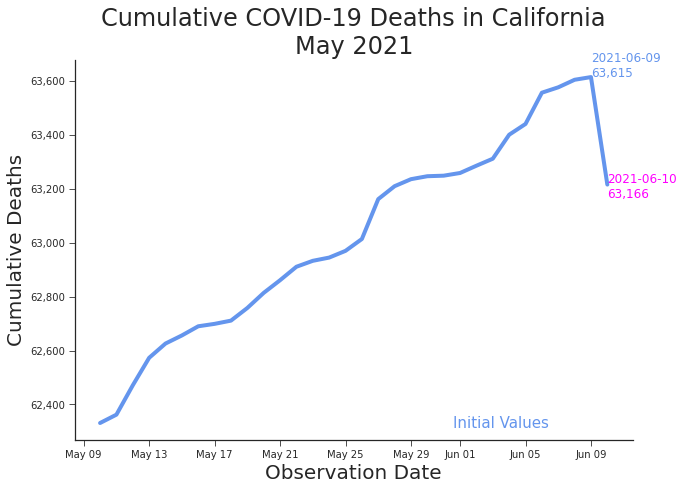

In [19]:
plt.clf()
plt, ax, setupdct = vs.setup_plot(
    df,
    title="",
    data_title="Cumulative COVID-19 Deaths in California\nMay 2021", x_label="Observation Date", y_label="Cumulative Deaths",
    num_rows=1, num_cols=1, y_scale="linear"
)
plt.plot(rdict["first_reported"]["2021-05-10": "2021-06-10"], lw=4, color='cornflowerblue')
plt.gcf().text(.65, .15, 'Initial Values',color='cornflowerblue', fontsize=15)
plt.title("Cumulative COVID-19 Deaths in California\nMay 2021")

# label the two points of interest
date1, date2 = "2021-06-09", "2021-06-10"
x1, y1 = rdict['first_reported']["2021-05-10": date1].index[-1], rdict['first_reported'][date1]
x2, y2 = rdict['first_reported']["2021-05-10": date2].index[-1], rdict['first_reported'][date2]
y2 -= 50
ax.text( x1 , y1 , f'{date1}\n{int(y1):,}', color="cornflowerblue", size=12)
ax.text( x2 , y2 , f'{date2}\n{int(y2):,}', color="magenta", size=12)

# make the y axis human readable
ax.get_yaxis().set_major_formatter(mtk.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.savefig("../latex/plots/simulations/JHU_California_deaths_decrease_detail_2022-06-09_fr.png")

 ## Plot the Restatement

<Figure size 432x288 with 0 Axes>

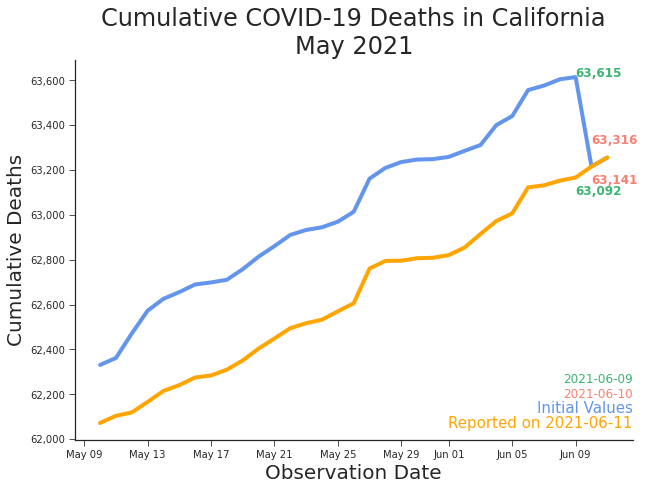

In [20]:
plt.clf()
plt, ax, setupdct = vs.setup_plot(
    df,
    title="",
    data_title="Cumulative COVID-19 Deaths in California\nMay-June 2021", x_label="Observation Date", y_label="Cumulative Deaths",
    num_rows=1, num_cols=1, y_scale="linear"
)
plt.plot(rdict["first_reported"]["2021-05-10": "2021-06-11"], lw=4, color='cornflowerblue')
plt.plot(df["2021-06-11"]["2021-05-10": "2021-06-11"], lw=4, color='orange')
plt.gcf().text(.9, .18, 'Initial Values',color='cornflowerblue', fontsize=15, ha='right')
plt.gcf().text(.9, .15, 'Reported on 2021-06-11',color='orange', fontsize=15, ha='right')

# label the two points of interest
date1, date2 = "2021-06-09", "2021-06-10"
x1, y1 = rdict['first_reported']["2021-05-10": date1].index[-1], rdict['first_reported'][date1]
x2, y2 = rdict['first_reported']["2021-05-10": date2].index[-1], rdict['first_reported'][date2]
y2 += 100
ax.text( x1 , y1 , f'{int(y1):,}', color="mediumseagreen", size=12, weight="bold")
ax.text( x2 , y2 , f'{int(y2):,}', color="salmon", size=12, weight="bold")
y1, y2 = df['2021-06-11'][date1] -75 , df['2021-06-11'][date2] -75
ax.text( x1 , y1 , f'{int(y1):,}', color="mediumseagreen", size=12, weight="bold")
ax.text( x2 , y2 , f'{int(y2):,}', color="salmon", size=12, weight="bold")
plt.gcf().text(.9, .24, f'{date1}',color='mediumseagreen', fontsize=12, ha='right')
plt.gcf().text(.9, .21, f'{date2}',color='salmon', fontsize=12, ha='right')
plt.title("Cumulative COVID-19 Deaths in California\nMay 2021")
# make the axis human readable
ax.get_yaxis().set_major_formatter(mtk.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.savefig("../latex/plots/simulations/JHU_California_deaths_restatement_detail_2022-06-09_fr.png")

 ## Plot the May Restatement

<Figure size 432x288 with 0 Axes>

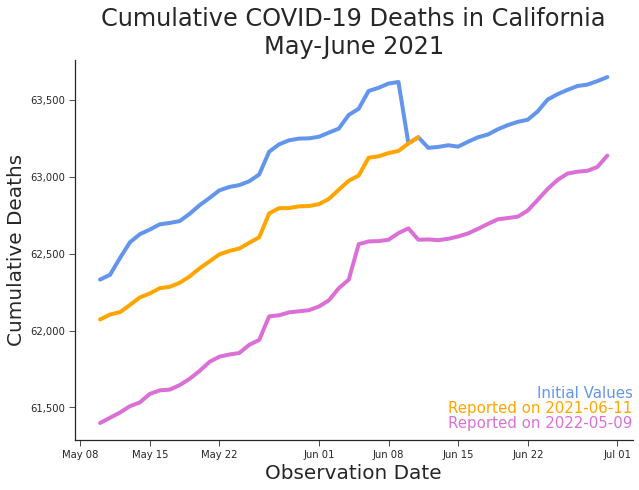

In [21]:
plt.clf()
plt, ax, setupdct = vs.setup_plot(
    df,
    title="",
    data_title="Cumulative COVID-19 Deaths in California\nMay-June 2021", x_label="Observation Date", y_label="Cumulative Deaths",
    num_rows=1, num_cols=1, y_scale="linear"
)
plt.plot(rdict["first_reported"]["2021-05-10": "2021-06-30"], lw=4, color='cornflowerblue')
plt.plot(df["2021-06-11"]["2021-05-10": "2021-06-30"], lw=4, color='orange')
plt.plot(df["2022-05-09"]["2021-05-10": "2021-06-30"], lw=4, color='orchid')
plt.gcf().text(.9, .21, 'Initial Values',color='cornflowerblue', fontsize=15, ha='right')
plt.gcf().text(.9, .18, 'Reported on 2021-06-11',color='orange', fontsize=15, ha='right')
plt.gcf().text(.9, .15, 'Reported on 2022-05-09',color='orchid', fontsize=15, ha='right')
plt.title("Cumulative COVID-19 Deaths in California\nMay-June 2021")

# make the axis human readable
ax.get_yaxis().set_major_formatter(mtk.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.savefig("../latex/plots/simulations/JHU_California_deaths_restatement_detail_2022-06-09.png")

# October 2021: Moving and Disappearing Deaths

In [22]:
ret = vs.within_release_shifts(df, alpha=1, window=21, func=lambda x: max(abs(x)), limit = 20)

In [23]:
desc = ret.dropna(axis=0, how="all").dropna(axis=1, how="all")
desc[desc > 0].dropna(how='all')

,2021-04-13,2021-04-14,2021-04-15,2021-04-16,2021-04-17,2021-04-18,2021-05-01,2021-05-02,2021-05-03,2021-05-04,...,2022-06-02,2022-06-03,2022-06-04,2022-06-05,2022-06-06,2022-06-07,2022-06-08,2022-06-09,2022-06-10,2022-06-11
2021-04-30,NaN,NaN,NaN,NaN,NaN,NaN,1.388235,1.388235,1.388235,1.388235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


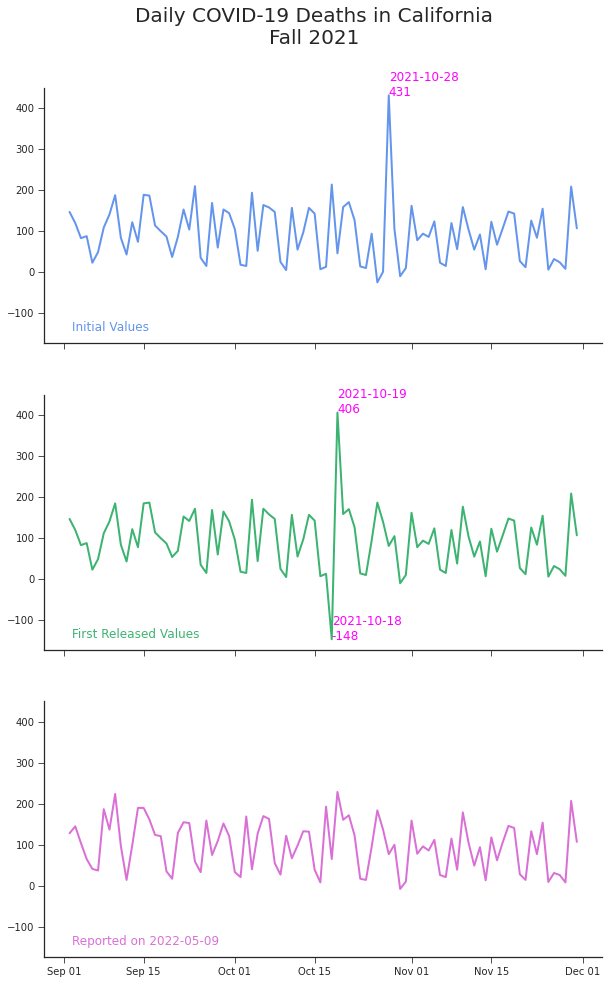

In [24]:
plt.close("all")

start = '2021-09-01'
stop = '2021-11-30'
first = rdict['first_reported'][start: stop].dropna()
first_e = rdict['first_expected_reported'][start: stop].dropna()
current = df['2022-05-09'][start: stop].dropna()

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 16))

for ax in axs:
    ax.set_ylim(-175, 450)

# earliest reported
axs[0].plot(first.index, first.diff(), lw=2, color='cornflowerblue')
axs[0].text(0.05, 2.45, f'Initial Values', color='cornflowerblue', fontsize=12, transform=ax.transAxes)
date = '2021-10-28'
x, y = first[[date]].index[0], first.diff()[date]
axs[0].text(x, y, f'{date}\n{int(y)}', color='magenta', fontsize=12)


# earliest expected
axs[1].plot(first_e.index, first_e.diff(), lw=2, color='mediumseagreen')
axs[1].text(0.05, 1.25, f'First Released Values', color='mediumseagreen', fontsize=12, transform=ax.transAxes)
date = '2021-10-19'
x, y = first_e[[date]].index[0], first_e.diff()[date]
axs[1].text(x, y, f'{date}\n{int(y)}', color='magenta', fontsize=12)
date = '2021-10-18'
x, y = first_e[[date]].index[0], first_e.diff()[date]
axs[1].text(x, y, f'{date}\n{int(y)}', color='magenta', fontsize=12)


# 2022-05-09 restatement
axs[2].plot(current.index, current.diff(), lw=2, color='orchid')
axs[2].text(0.05, 0.05, f'Reported on 2022-05-09', color='orchid', fontsize=12, transform=ax.transAxes)

plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

fig.suptitle("Daily COVID-19 Deaths in California\nFall 2021", size=20, y=.95)
# plt.tight_layout()
plt.savefig("../latex/plots/simulations/JHU_California_deaths_changes_2021-10.png",  bbox_inches="tight")
# plt.close("all")

In [25]:
vs.df_to_latex(df.loc['2021-10-16':'2021-10-20' , '2021-10-16':'2021-10-20'], "Cumulative Deaths CA (JHU)")

# DO NOT ADD BELOW TO SCRIPT

In [26]:
from jupyckage.jupyckage import notebook_to_package
import shutil

to_latex_folder = "../latex/code/notebooks/"

notebook_name = "MotivatingExample"

notebook_to_package(f'{notebook_name}.ipynb')

shutil.copy( f'notebooks/src/{notebook_name}/{notebook_name}.py', f'{to_latex_folder}{notebook_name}.py')

'../latex/code/notebooks/MotivatingExample.py'